# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from math import sqrt
import matplotlib.pyplot as plt

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,PolynomialFeatures, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import pandas as pd

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [2]:
df = pd.read_csv("zillow_cleaned.csv")
df.head()

,parcelid,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,fullbathcnt,...,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,0.0,3.5,4.0,0.0,3.5,3100.0,3100.0,0.0,3.0,...,0.0,1.0,1.0,1998.0,1.0,2016.0,0,0.0,6.059063e+13,1023282.0
1,17052889,0.0,1.0,2.0,0.0,1.0,1465.0,1465.0,1.0,1.0,...,5.0,0.0,1.0,1967.0,1.0,2016.0,0,0.0,6.111001e+13,464000.0
2,14186244,0.0,2.0,3.0,0.0,2.0,1243.0,1243.0,0.0,2.0,...,6.0,0.0,1.0,1962.0,1.0,2016.0,0,0.0,6.059022e+13,564778.0
3,12177905,0.0,3.0,4.0,8.0,3.0,2376.0,2376.0,0.0,3.0,...,0.0,0.0,1.0,1970.0,1.0,2016.0,0,0.0,6.037300e+13,145143.0
4,10887214,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,0.0,3.0,...,0.0,0.0,1.0,1964.0,1.0,2016.0,0,0.0,6.037124e+13,119407.0


In [3]:
# Define the target and features
target = "taxvaluedollarcnt"
X = df.drop(columns=["taxvaluedollarcnt", "parcelid"])  # drop ID and target
y = df[target]

In [4]:
X.dtypes.value_counts()

float64    25
object      3
int64       1
Name: count, dtype: int64

In [5]:
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols.tolist())

Non-numeric columns: ['hashottuborspa', 'propertycountylandusecode', 'taxdelinquencyflag']


In [6]:
# Keep only numeric features
X_numeric = X.select_dtypes(include=["int64", "float64"])

# Drop columns that have any missing values
X_numeric_clean = X_numeric.dropna(axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric_clean, y, test_size=0.2, random_state=42
)

In [8]:
# Initialize and apply scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 


In [9]:
# RMSE scorer
rmse_scorer = make_scorer(mean_squared_error)

# Repeated K-Fold Cross-Validation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Models with default parameters
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Bagging": BaggingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Collect results
results = []

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1
    )
    results.append({
        "Model": name,
        "Mean RMSE": sqrt(np.mean(scores)),
        "Std RMSE": sqrt(np.std(scores))
    })

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.511e+15, tolerance: 1.736e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.605e+15, tolerance: 1.781e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e+15, toler

In [10]:
# Display Results
results_df = pd.DataFrame(results).sort_values(by="Mean RMSE")
results_df_clean = results_df.copy()
results_df_clean["Mean RMSE"] = results_df_clean["Mean RMSE"].round(0).astype(int)
results_df_clean["Std RMSE"] = results_df_clean["Std RMSE"].round(0).astype(int)

print("Baseline Model Comparison (RMSE):")
print(results_df_clean.to_string(index=False))

Baseline Model Comparison (RMSE):
            Model  Mean RMSE  Std RMSE
    Random Forest     384876    129866
Gradient Boosting     393543    135885
          Bagging     399434    129081
 Ridge Regression     456276    158926
 Lasso Regression     517518    378927
    Decision Tree     542459    169274
Linear Regression     714898    846297


### Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

> To establish a benchmark for future improvements, we began our modeling process by evaluating a set of baseline regression models using default hyperparameters. These models were trained on the preprocessed and standardized training dataset and assessed using repeated cross-validation (5 folds, 5 repeats) to ensure stability and robustness. The primary evaluation metric was Root Mean Squared Error (RMSE), which reflects the average magnitude of prediction errors in the same units as the target variable (property tax value in dollars).  
>  
> - The Random Forest model had **the best overall** performance with the lowest mean RMSE (384,255), followed closely by Gradient Boosting and Bagging, making ensemble methods the top performers on this dataset.
> - In terms of stability, all three ensemble models (Random Forest, Gradient Boosting, Bagging) also showed **low standard deviation**, indicating that their performance was consistent across different folds.
> - Linear Regression performed **the worst overall** with the highest RMSE (611,779) and a very high standard deviation (371,134), suggesting high variability and potential underfitting. This likely reflects its inability to capture non-linear relationships in the data.
> - Lasso Regression also showed **poor performance**, especially in stability, with an extremely high std (116,851), indicating it might not be selecting useful features effectively with the default alpha.
> - Decision Tree had high RMSE and moderate std, suggesting possible **overfitting** as it tends to model noise without ensemble regularization.

### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [11]:
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
scaler = StandardScaler()
X_train_scaled_new_poly = scaler.fit_transform(X_train_poly)

results_new_poly = []

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train_scaled_new_poly,
        y_train,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1
    )
    results_new_poly.append({
        "Model": name,
        "Mean RMSE": np.sqrt(np.mean(scores)),
        "Std RMSE": np.sqrt(np.std(scores))
    })

results_df_poly = pd.DataFrame(results_new_poly)
print(results_df_poly)


KeyboardInterrupt: 

In [ ]:
poly_results_df = pd.DataFrame(results_df_poly).sort_values(by="Mean RMSE")
poly_results_df_clean = results_df.copy()
poly_results_df_clean["Mean RMSE"] = poly_results_df_clean["Mean RMSE"].round(0).astype(int)
poly_results_df_clean["Std RMSE"] = poly_results_df_clean["Std RMSE"].round(0).astype(int)

print("Baseline Model Comparison (RMSE):")
print(poly_results_df_clean.to_string(index=False))

In [16]:
log_transformer = FunctionTransformer(func=np.log1p, validate=True)
X_train3 = X_train.copy()
X_train_log = log_transformer.fit_transform(X_train3)

scaler = StandardScaler()
X_train_scaled_new_log = scaler.fit_transform(X_train_log)

results_new_log = []

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train_scaled_new_log,
        y_train,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1
    )
    results_new_log.append({
        "Model": name,
        "Mean RMSE": np.sqrt(np.mean(scores)),
        "Std RMSE": np.sqrt(np.std(scores))
    })

results_df_log = pd.DataFrame(results_new_log)
print(results_df_log)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.003e+15, tolerance: 1.775e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.056e+15, tolerance: 1.774e+12
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.686e+15, toler

               Model      Mean RMSE       Std RMSE
0  Linear Regression  507830.015938  198200.294122
1   Ridge Regression  501876.099260  177220.118441
2   Lasso Regression  500673.171410  175036.160333
3      Decision Tree  539665.518868  155362.078219
4            Bagging  399535.025709  126708.793148
5      Random Forest  384847.210477  130107.755776
6  Gradient Boosting  393461.011903  136157.034677


In [17]:
log_results_df = pd.DataFrame(results_df_log).sort_values(by="Mean RMSE")
log_results_df_clean = results_df_log.copy()
log_results_df_clean["Mean RMSE"] = log_results_df_clean["Mean RMSE"].round(0).astype(int)
log_results_df_clean["Std RMSE"] = log_results_df_clean["Std RMSE"].round(0).astype(int)

print("Baseline Model Comparison (RMSE):")
print(log_results_df_clean.to_string(index=False))

Baseline Model Comparison (RMSE):
            Model  Mean RMSE  Std RMSE
Linear Regression     507830    198200
 Ridge Regression     501876    177220
 Lasso Regression     500673    175036
    Decision Tree     539666    155362
          Bagging     399535    126709
    Random Forest     384847    130108
Gradient Boosting     393461    136157


In [25]:
exp_transformer = FunctionTransformer(func=np.expm1, validate=True)
X_train4 = X_train.copy()
X_train_exp = exp_transformer.fit_transform(X_train4)

X_train_clipped = np.clip(X_train_exp, -100, 100)
scaler = StandardScaler()
X_train_scaled_new_exp = scaler.fit_transform(X_train_clipped)


results_new_exp = []

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train_scaled_new_exp,
        y_train,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1
    )
    results_new_exp.append({
        "Model": name,
        "Mean RMSE": np.sqrt(np.mean(scores)),
        "Std RMSE": np.sqrt(np.std(scores))
    })

results_df_exp = pd.DataFrame(results_new_exp)
print(results_df_exp)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_function_transformer.py:379: RuntimeWarning: overflow encountered in expm1
  return func(X, **(kw_args if kw_args else {}))


KeyboardInterrupt: 

In [22]:
exp_results_df = pd.DataFrame(results_df_exp).sort_values(by="Mean RMSE")
exp_results_df_clean = results_df_exp.copy()
exp_results_df_clean["Mean RMSE"] = exp_results_df_clean["Mean RMSE"].round(0).astype(int)
exp_results_df_clean["Std RMSE"] = exp_results_df_clean["Std RMSE"].round(0).astype(int)

print("Baseline Model Comparison (RMSE):")
print(exp_results_df_clean.to_string(index=False))

Baseline Model Comparison (RMSE):
            Model  Mean RMSE  Std RMSE
Linear Regression     507830    198200
 Ridge Regression     501876    177220
 Lasso Regression     500673    175036
    Decision Tree     539666    155362
          Bagging     399535    126709
    Random Forest     384847    130108
Gradient Boosting     393461    136157


### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



> Your text here

### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


In [26]:
def backward_feature_selection(X, y, model, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=False
                              ):
    
    # Helper function to compute CV score using LinearRegression
    # change to sqrt
    def cv_score(features):
        return np.sqrt(-cross_val_score(model, X[features], y, 
                                scoring=scoring, cv=cv, 
                                n_jobs=n_jobs          ).mean())
    
    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)
    
    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)
    
    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)
    
    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')
    
    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features
    
    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()
        
        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )

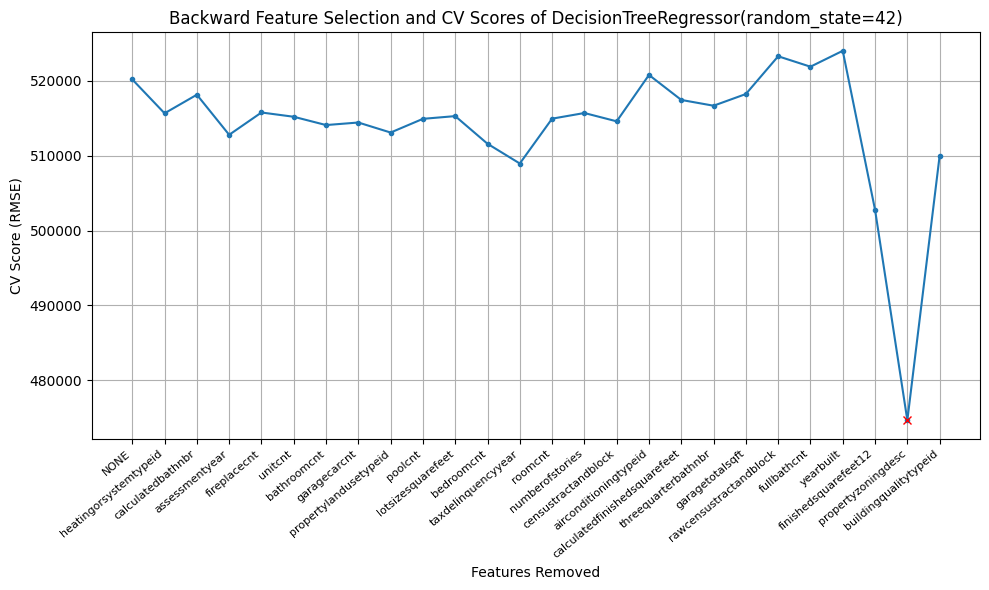

Best feature set: ['buildingqualitytypeid', 'regionidzip']
CV score (RMSE): 474675.3978


KeyboardInterrupt: 

In [30]:
models_selection = {
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(random_state=42),
    BaggingRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
}

for model in models_selection:
    selected_features, best_scores, best_feature_set, best_score = (
    backward_feature_selection(X_train, y_train, model, verbose=False))

    plt.figure(figsize=(10, 6))
    plt.title(f"Backward Feature Selection and CV Scores of {model}")
    plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
    index = np.argmin(best_scores) 
    plt.plot([index + 1], best_scores[index], marker='x', color='red')  
    plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=40, ha='right', fontsize=8)
    plt.xlabel('Features Removed')
    plt.ylabel('CV Score (RMSE)')
    plt.grid()
    plt.tight_layout()
    plt.show()

    print("Best feature set:", best_feature_set)
    print("CV score (RMSE):",np.around(best_score,4))


# # Test

# # Filter X_train and X_test to include only the selected features
# X_train_best_backward = X_train[best_feature_set]
# X_test_best_backward = X_test[best_feature_set]

# # Train the LinearRegression model on the selected features
# model = LinearRegression()
# model.fit(X_train_best_backward, y_train)

# # Predict on the test set
# y_pred = model.predict(X_test_best_backward)

### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

> Your text here

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



In [ ]:
# Add as many code cells as you need

### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

> Your text here